## Create an NWB 2.0 File with Frank Lab data

This notebook shows how to create an [Neurodata Without Borders: Neurophysiology (NWB:N)](https://neurodatawithoutborders.github.io/) file from publicly available Frank Lab data. We will create an NWB file storing one day of data from one animal, inlcluding both awake behaving and sleep epochs, using the [PyNWB](https://pynwb.readthedocs.io/en/latest/) API. You can think of the PyNWB API as a toolbox for working with NWB files in the Python programming language.

We will use the [hc-6 dataset](https://crcns.org/data-sets/hc/hc-6/about-hc-5), collected by Dr. Mattias Karlsson and Dr. Margaret Carr working in the lab of Dr. Loren Frank. While these data are publicly available, please read the section titled "Conditions for using the data" on CRCNS. After setting up an account with CRCNS, you can download the data via the link in the section titled "How to download data." Each animal's compressed data will be around 3 GB. 

Instructions:
1. If you don't already have an account with CRCNS, create one.
2. Download the data for animal Bon from the CRCNS [hc-6 dataset](https://crcns.org/data-sets/hc/hc-6/about-hc-5) and uncompress it. You should see a directory called "Bon".
3. In the second cell of this notebook (after importing dependencies), update the "data_dir" variable to the full path to your "Bon" directory.
4. Run each cell in order. We recommend reading the cell header comments and waiting for each cell to complete to read the outputs along the way.

Note: If you encounter any errors, the first thing to try is to restart the kernel and re-run the cells. (When you write your own import script you should not use a notebook to run it, but rather use a script or function, to ensure that all steps are run in the specified order.)

After completing this notebook, you might be interested in the 'place_field_with_queries.ipynb' notebook for a demonstration / sneak peak of how Frank Lab NWB files can be effectively queried to run a canonical place field analysis. That notebook introduces a set of useful query classes, which are still in bata phase but could become incorporated into PyNWB in the future.



### Import dependencies

In [3]:
%load_ext autoreload
%autoreload 2

import pynwb

# General dependencies
import os
import numpy as np

# Time
from datetime import datetime
from dateutil import tz

# Helpers for parsing Frank Lab Matlab data
import nspike_helpers as ns 

# Frank Lab PyNWB extensions and extension-related helpers
import fl_extension as fle
import fl_extension_helpers as flh

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Which data do you want to load?

We will create an NWB file storing data from one experimental day for one animal.

In [4]:
# -------
# ~ ~ ~ ~ UPDATE THIS VARIABLE WITH THE PATH TO YOUR DATA ~ ~ ~ ~
# -------
# Path to your data directory (e.g. the directory called "Bon" downloaded from CRCNS)
data_dir = os.path.expanduser('~/Data/CRCNS/Bon')
assert(os.path.isdir(data_dir)), "Data directory does not exist! Update path."

# -------
# You don't need to change these unless you are trying out other days or animals.
# We recommend starting with animal 'Bon', day 4.
# -------
day = 4
animal = 'Bon'

# We don't know the exact date and time this experiment was actually conducted, so we use a placeholder date.
dataset_zero_time = datetime(2006, 1, day, 12, 0, 0, tzinfo=tz.gettz('US/Pacific'))

# Recording parameters needed for import:
eeg_samprate = 1500.0 # Hz

### Initialize the new NWBFile object

The PyNWB API provides a set of easily-used functions that allow us to store our data in the
appropriate places for eventually saving as a valid NWB file.

In [5]:
nwbf = pynwb.NWBFile(
           session_description='Frank Lab CRCNS data for animal {0}, day {1}'.format(animal, day),
           identifier='{0}{1:04}'.format(animal, day),
           session_start_time=dataset_zero_time,
           file_create_date=datetime.now(tz.tzlocal()),
           lab='Frank Laboratory',
           experimenter='Mattias Karlsson',
           institution='UCSF',
           experiment_description='Tetrode recordings from behaving rat on W-Track and during sleep',
           session_id=data_dir)

print("Here is the top-level structure of our new (still mostly empty) object:")
print(nwbf)

Here is the top-level structure of our new (still mostly empty) object:

root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: { }
  analysis: { }
  devices: { }
  electrode_groups: { }
  epoch_tags: {}
  experiment_description: Tetrode recordings from behaving rat on W-Track and during sleep
  experimenter: Mattias Karlsson
  ic_electrodes: { }
  imaging_planes: { }
  institution: UCSF
  lab: Frank Laboratory
  lab_meta_data: { }
  modules: { }
  ogen_sites: { }
  session_id: /Users/tjd/Data/CRCNS/Bon
  stimulus: { }
  stimulus_template: { }
  time_intervals: { }



### Process tetrodes metadata

1. Each tetrode gets an [ElectrodeGroup](https://pynwb.readthedocs.io/en/latest/pynwb.ecephys.html#pynwb.ecephys.ElectrodeGroup), where we store metadata about the tetrode such a unique name and the region of the brain it's in. 

2. Each individual recording channel (i.e. each of the 4 tetrode channels) gets its own row in the top-level [NWBFile.electrodes](https://pynwb.readthedocs.io/en/latest/pynwb.file.html?highlight=epochs#pynwb.file.NWBFile.electrodes) table. Here we store metadata about the electrode such as its location/depth in the brain, and the tetrode that it is part of.  We use the [NWBFile.add_electrode()](https://pynwb.readthedocs.io/en/latest/pynwb.file.html#pynwb.file.NWBFile.add_electrode) method to add each channel. As with the NWBFile.epochs table, discussed above, this is a DynamicTable.

3. Each tetrode gets an "Electrode Table Region", an instance of [DynamicTableRegion](https://pynwb.readthedocs.io/en/latest/pynwb.core.html?highlight=DynamicTableRegion#pynwb.core.DynamicTableRegion). This is just a slice into the [NWBFile.electrodes](https://pynwb.readthedocs.io/en/latest/pynwb.file.html?highlight=epochs#pynwb.file.NWBFile.electrodes) table selecting the channels that go with the tetrode. We use the [create_electrode_table_region()]() method to add each tetrode's Electrode Table Region.

4. Since LFP is often taken from a subset of a tetrode's channels, we create an Electrode Table Region for each tetrode's LFP channles. For example, if LFP was taken from just the first channel of a tetrode, we would create an Electrode Table Region just pointing to that channel of the [NWBFile.electrodes](https://pynwb.readthedocs.io/en/latest/pynwb.file.html?highlight=epochs#pynwb.file.NWBFile.electrodes) table.

In [6]:
# Parse tetrodes metadata from the old Frank Lab Matlab files
tetrode_metadata = ns.parse_franklab_tetrodes(data_dir, animal, day)

# Represent our acquisition system with a 'Device' object
recording_device = nwbf.create_device(name='NSpike acquisition system')

# Four channels per tetrode by definition 
num_chan_per_tetrode = 4     

# Initialize dictionaries to store the metadata
tet_electrode_group = {}  # group for each tetrode
tet_electrode_table_region = {}  # region for each tetrode (all channels)
lfp_electrode_table_region = {}  # region for each tetrode's LFP channels

chan_num = 0   # Incrementing channel number
for tet_num, tet in tetrode_metadata.items():
    
    # Define some metadata parameters
    tetrode_name = "%02d-%02d" % (day, tet_num) 
    impedance = np.nan
    filtering = 'unknown - likely 600Hz-6KHz'
    location = ns.get_franklab_tet_location(tet)  # area/subarea in the brain
    depth = ns.get_franklab_tet_depth(tet)  # depth in the brain
    description = "tetrode {tet_num} located in {location} on day {day}".format(
        tet_num=tet_num, location=location, day=day)
    
    # 1. Represent the tetrode in NWB as an ElectrodeGroup
    tet_electrode_group[tet_num] = nwbf.create_electrode_group(name=tetrode_name,
                                                               description=description,
                                                               location=location,
                                                               device=recording_device)
    
    # 2. Represent each channels of the tetrode as a row in the NWBFile.electrodes table.
    #    We do not have x and y coordinates for electrodes, so we set to np.nan.
    for i in range(num_chan_per_tetrode):
            nwbf.add_electrode(x=np.nan,  
                               y=np.nan,
                               z=depth,
                               imp=impedance,
                               location=location,
                               filtering=filtering,
                               group=tet_electrode_group[tet_num],  # tetrode this electrode belongs to
                               group_name=tet_electrode_group[tet_num].name,
                               id=chan_num)
            chan_num = chan_num + 1  # total number of channels processed so far across all tets
            
    # 3. Create an Electrode Table Region (slice into the electrodes table) for each tetrode
    table_region_description = 'tetrode %d all channels' % tet_num
    table_region_name = '%d' % tet_num
    table_region_rows = list(range(chan_num - num_chan_per_tetrode, chan_num)) # rows of NWBFile.electrodes table
    tet_electrode_table_region[tet_num] = nwbf.create_electrode_table_region(
        region=table_region_rows,
        description=table_region_description,
        name=table_region_name)

    # 4. Create an ElectrodeTableRegion for each tetrode's LFP recordings
    lfp_channels = [chan_num - num_chan_per_tetrode] # Assume that LFP is taken from the first channel
    table_region_description = 'tetrode %d LFP channels' % tet_num
    lfp_electrode_table_region[tet_num] = nwbf.create_electrode_table_region(
        region=lfp_channels,
        description=table_region_description,
        name='electrodes')

print("Here is an example ElectrodeGroup for a tetrode: ")
print(tet_electrode_group[1])
print('\n')
print("Here is the ElectrodeTableRegion for that tetrode:")
print(tet_electrode_table_region[1])
print('\n')
print("Here is an example channel from the NWBFile.electrodes table:")
print(nwbf.electrodes.to_dataframe().iloc[0, :])

Here is an example ElectrodeGroup for a tetrode: 

04-01 <class 'pynwb.ecephys.ElectrodeGroup'>
Fields:
  description: tetrode 1 located in CA3 on day 4
  device: NSpike acquisition system <class 'pynwb.device.Device'>
  location: CA3



Here is the ElectrodeTableRegion for that tetrode:

1 <class 'pynwb.core.DynamicTableRegion'>
Fields:
  description: tetrode 1 all channels
  table: electrodes <class 'pynwb.core.DynamicTable'>



Here is an example channel from the NWBFile.electrodes table:
x                                                           NaN
y                                                           NaN
z                                                       3.94229
imp                                                         NaN
location                                                    CA3
filtering                           unknown - likely 600Hz-6KHz
group         \n04-01 <class 'pynwb.ecephys.ElectrodeGroup'>...
group_name                                             

### Process LFP

We store LFP data from all of our tetrodes in a single [LFP](https://pynwb.readthedocs.io/en/latest/pynwb.ecephys.html?highlight=LFP#pynwb.ecephys.LFP) object. We use the [LFP.create_electrical_series()](https://pynwb.readthedocs.io/en/latest/pynwb.ecephys.html?highlight=LFP#pynwb.ecephys.LFP.create_electrical_series) method to create a new [ElectricalSeries](https://pynwb.readthedocs.io/en/latest/pynwb.ecephys.html?highlight=LFP#pynwb.ecephys.ElectricalSeries) for each tetrode, where we can store its electical data, timestamps, and the channels used to record the data.

After putting the LFP data from all the tetrodes in an [LFP](https://pynwb.readthedocs.io/en/latest/pynwb.ecephys.html?highlight=LFP#pynwb.ecephys.LFP) object, we add this object to the NWBFile using the [add_acquisition()](https://pynwb.readthedocs.io/en/latest/pynwb.file.html?highlight=Acquisition#pynwb.file.NWBFile.add_acquisition) method.  This puts it in [NWBFile.acquisition](https://pynwb.readthedocs.io/en/latest/pynwb.file.html?highlight=Acquisition#pynwb.file.NWBFile.acquisition), which is just a bucket where we put raw timeseries data like LFP. 

Note that we <i>don't</i> put the LFP in a ProcessingModule (located in NWBFile.modules) like we did for behavioral data.  Furthermore, there is another top-level bucket called NWBFile.analysis. Where we choose to put our datasets is a judgment call based on convention. If you are ever usure where to find something, you can always print the NWBFile to inspect its contents.




In [7]:
print("Processing LFP data. This could take up to a minute...\n")
# Get a list of all the LFP files
eeg_path = os.path.join(data_dir, 'EEG')  # look in a subdirectory called EEG
eeg_files = ns.get_eeg_by_day(eeg_path, animal.lower(), 'eeg')

# Intialize a new ecephys.LFP object to store LFP from all of our tetrodes.
lfp = pynwb.ecephys.LFP()

# Process and store the LFP from each tetrode
eeg_samprate = 1500.0 # Hz
for tet_num in tetrode_metadata.keys():
    # Give a unique name to this tetrode's LFP data
    lfp_name = "{prefix}eeg-{day}-{tet}".format(prefix=animal.lower(), day=day, tet=tet_num)
    
    # Parse the LFP from Frank Lab Matlab files
    timestamps, data = ns.build_day_eeg(eeg_files[day][tet_num], eeg_samprate)
    data /= 1000 # convert from mV to V
    timestamps += dataset_zero_time.timestamp()  # convert to POSIX time
    
    # Add LFP as a new ElectricalSeries in the ecephys.LFP object
    lfp.create_electrical_series(name=lfp_name, 
                                 data=data,
                                 electrodes=lfp_electrode_table_region[tet_num],
                                 timestamps=timestamps)
    
# Add the ecephys.LFP object to the NWBFile
nwbf.add_acquisition(lfp)

print("Here is NWBFile.acquisition, where we put our LFP object.\nNotice that each tetrode has a different ElectricalSeries.\n")
print(nwbf.acquisition)

Processing LFP data. This could take up to a minute...

Here is NWBFile.acquisition, where we put our LFP object.
Notice that each tetrode has a different ElectricalSeries.

{'LFP': 
LFP <class 'pynwb.ecephys.LFP'>
Fields:
  electrical_series: { boneeg-4-1 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-10 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-11 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-12 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-13 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-14 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-15 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-17 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-18 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-19 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-2 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-20 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-21 <class 'pynwb.ecephys.ElectricalSeries'>,  boneeg-4-22 <class 'pynwb.ecephys.Electri

### Store spike-sorted data

We will use the top-level [Units](https://pynwb.readthedocs.io/en/stable/pynwb.misc.html#pynwb.misc.Units) table to store spike times and other information about clustered single units from our recordings.

In addition to the times of spike events, we also need to store the time intervals over which the cluster was being observed. We store this in the optional `obs_intervals` field. See the notebook 'place_field_with_queries' to see how we use this data during analysis.

In [8]:
# Constants for processing spikes
timestamps_column = 0  # index of the timestamps column in the units table
NSpike_timestamps_per_sec = 10000

# ------------
# Add some metadata columns to the NWBFile.units table
# ------------
nwbf.add_unit_column('cluster_name',  'cluster name from clustering software')
nwbf.add_unit_column('sorting_metric', 'a sorting metric for this unit') 

# ------------
# Load spiking data into a dictionary ordered by [tetrode num][cluster num][epoch]
# ------------
spiking_data = ns.parse_franklab_spiking_data(data_dir, animal, day)

# ------------
# Add each cluster to the NWBFile.units table, concatenating the data across epochs
# and keeping track of observation intervals
# ------------
cluster_id = 0  # increment for each cluster we process
for tet_num in spiking_data.keys():
    for cluster_num in spiking_data[tet_num].keys():
    
        # Collect spike times and obs intervals for every epoch in this cluster
        cluster_spikes = spiking_data[tet_num][cluster_num] # dictionary indexed by epoch
        spike_times_each_epoch = []
        obs_int_each_epoch = np.zeros([0,2])
        for epoch in cluster_spikes.keys():
            # Get this cluster's spikes for this epoch
            if cluster_spikes[epoch]['data'].shape[0]:
                epoch_data = cluster_spikes[epoch]['data'][:, timestamps_column]
                spike_times_each_epoch.append(epoch_data + dataset_zero_time.timestamp())
            # Get this cluster's observation intervals for this epoch
            for epoch_obs_int in cluster_spikes[epoch]['timerange']:
                # Convert from Nspike timestamps to POSIX time
                epoch_obs_int = epoch_obs_int.T.astype(float) / NSpike_timestamps_per_sec + dataset_zero_time.timestamp()
                obs_int_each_epoch = np.append(obs_int_each_epoch, [epoch_obs_int], axis=0)

        # Concatenate the spiketimes across epochs. 
        spiketimes = np.concatenate(spike_times_each_epoch)  
        
        # Add this cluster to the NWBFile.units table
        cluster_name = 'd%d t%d c%d' % (day, tet_num, cluster_num)
        nwbf.add_unit(spike_times= spiketimes,
                      electrodes=tet_electrode_table_region[tet_num].data,
                      electrode_group=tet_electrode_group[tet_num], 
                      obs_intervals=obs_int_each_epoch,
                      id = cluster_id,
                      cluster_name=cluster_name,
                      sorting_metric=-1, # dummy value
                     )
        cluster_id += 1        

print("Here is an example row from the NWBFile.units table:")
print(nwbf.units.to_dataframe().iloc[0, :])

Here is an example row from the NWBFile.units table:
cluster_name                                                d4 t1 c1
sorting_metric                                                    -1
spike_times        [1136405835.3038, 1136405838.406, 1136405838.4...
obs_intervals      [[1136405805.0, 1136407143.0], [1136407261.0, ...
electrodes         [(0, nan, nan, 3.9422916666666667, nan, CA3, u...
electrode_group    \n04-01 <class 'pynwb.ecephys.ElectrodeGroup'>...
Name: 0, dtype: object


### Initialize PyNWB objects for storing behavioral timeseries data

PyNWB provides several datatypes for specific kinds of behavior data. This allows anyone using PyNWB to know what kinds of data are stored in which places in the PyNWB file. However, all of these are examples of timeseries data (i.e. data with assocaited timestamps). Here, we use the following:
- spatial position (x/y) will be stored in a [Position](https://pynwb.readthedocs.io/en/latest/pynwb.behavior.html#pynwb.behavior.Position) object
- head direction (angle) will be stored in a [CompassDirection](https://pynwb.readthedocs.io/en/latest/pynwb.behavior.html#pynwb.behavior.CompassDirection) object
- speed (m/s) will be stored in a more general [BehavioralTimeSeries](https://pynwb.readthedocs.io/en/latest/pynwb.behavior.html#pynwb.behavior.BehavioralTimeSeries) object

These objects will later be used to store the specified types of data, but for now they are empty.

In [9]:
position = pynwb.behavior.Position(name='Position')
head_dir = pynwb.behavior.CompassDirection(name='Head Direction')
speed = pynwb.behavior.BehavioralTimeSeries(name='Speed')

print("Here are the PyNWB objects where we will store behavior data:")
print(position)
print(head_dir)
print(speed)

Here are the PyNWB objects where we will store behavior data:

Position <class 'pynwb.behavior.Position'>
Fields:
  spatial_series: { }


Head Direction <class 'pynwb.behavior.CompassDirection'>
Fields:
  spatial_series: { }


Speed <class 'pynwb.behavior.BehavioralTimeSeries'>
Fields:
  time_series: { }



### Parse animal behavior data
Next, we parse the behavioral data from the old Frank Lab Matlab files and create timeseries objects which we then add to the PyNWB datatypes we initialized above.
In the Frank Lab we concatenate the data across epochs into a single big (discontinuous) timeseries (i.e. there are no formal separations between epochs). Accessing particular epochs is done via time queries on the epoch start/stop times (see place_field_with_queries.ipynb).

We add the animal's 2D spatial position by calling the [create_spatial_series](https://pynwb.readthedocs.io/en/latest/pynwb.behavior.html?highlight=create_spatial_series#pynwb.behavior.Position.create_spatial_series) method on the 
PyNWB Position object. Similarly, for speed we use the [create_timeseries](https://pynwb.readthedocs.io/en/latest/pynwb.behavior.html?highlight=create_spatial_series#pynwb.behavior.BehavioralTimeSeries.create_timeseries) method on the PyNWB BehavioralTimeSeries object
to add the animal's speed for this epoch and day. The differences between these two are minimal.

In [10]:
behavior_data = ns.parse_franklab_behavior_data(data_dir, animal, day)
epoch_time_ivls = []
time_idx, x_idx, y_idx, dir_idx, vel_idx = range(5)  # column ordering of the behavioral data matrix


# Initialize empty arrays for behavior samples across all epochs
pos_samples = np.zeros((0, 2)) # x/y positions (n x 2)
dir_samples = np.array([])
speed_samples = np.array([])
behavior_timestamps = []  # behavior timestamps are shared

# Loop over each epoch of this day
for epoch_num, epoch_data in behavior_data.items():
    m_per_pixel = epoch_data['cmperpixel'][0,0]/100    # meters / pixel conversion factor
    
    # Behavior samples for this epoch (position, head direction, speed)
    epoch_pos_samples = epoch_data['data'][:, (x_idx, y_idx)] * m_per_pixel
    epoch_dir_samples = epoch_data['data'][:, dir_idx]
    epoch_speed_samples = epoch_data['data'][:, vel_idx] * m_per_pixel
    
    # Timestamps for this epoch (note that we convert timestamps to POSIX time)
    epoch_timestamps = epoch_data['data'][:, time_idx] + dataset_zero_time.timestamp()
    
    # Add this epoch's data to the array   
    pos_samples = np.concatenate((pos_samples, epoch_pos_samples), axis=0)
    dir_samples = np.concatenate((dir_samples, epoch_dir_samples), axis=0)
    speed_samples = np.concatenate((speed_samples, epoch_speed_samples), axis=0)
    behavior_timestamps = np.concatenate((behavior_timestamps, epoch_timestamps), axis=0)
    
    # Store the times of epoch start and end. We will use these later to build the 'epochs' table
    epoch_time_ivls.append([epoch_timestamps[0], epoch_timestamps[-1]])
    

# Add the across-epochs behavioral data to the PyNWB objects
# See place_field_with_queries.ipynb for examples of how we query these for specific epochs
position.create_spatial_series(name='Position', 
                               timestamps=behavior_timestamps, 
                               data=pos_samples, 
                               reference_frame='corner of video frame')

head_dir.create_spatial_series(name='Head direction', 
                               timestamps=behavior_timestamps, 
                               data=dir_samples, 
                               reference_frame='0=direction of top of video frame; ' + 
                                   'positive values clockwise (need to confirm this)')

speed.create_timeseries(name='Speed', 
                        timestamps=behavior_timestamps, 
                        data=speed_samples, 
                        unit='m/s', 
                        description='smoothed movement speed estimate')

    
print("Here are the same PyNWB objects, now filled with behavior data from each epoch:")
print(position)
print(head_dir)
print(speed)

Here are the same PyNWB objects, now filled with behavior data from each epoch:

Position <class 'pynwb.behavior.Position'>
Fields:
  spatial_series: { Position <class 'pynwb.behavior.SpatialSeries'> }


Head Direction <class 'pynwb.behavior.CompassDirection'>
Fields:
  spatial_series: { Head direction <class 'pynwb.behavior.SpatialSeries'> }


Speed <class 'pynwb.behavior.BehavioralTimeSeries'>
Fields:
  time_series: { Speed <class 'pynwb.base.TimeSeries'> }



### Add behavior objects to the NWBFile
Now that we have added the behavioral data to separate PyNWB objects (`position`, `head_dir`, `speed`), we need to put these objects into the appropriate place in the main `NWBFile` object. Specifically, we will add them to a [ProcessingModule](https://pynwb.readthedocs.io/en/latest/pynwb.base.html#pynwb.base.ProcessingModule), which is basically just a named bucket where we can store processed data of a particular type.  In our case, we will create a [ProcessingModule](https://pynwb.readthedocs.io/en/latest/pynwb.base.html#pynwb.base.ProcessingModule) called "behavior" for storing processed behavior data. All of the [ProcessingModules](https://pynwb.readthedocs.io/en/latest/pynwb.base.html#pynwb.base.ProcessingModule) that have been added can be found in [NWBFile.modules](https://pynwb.readthedocs.io/en/latest/pynwb.file.html?highlight=Acquisition#pynwb.file.NWBFile.modules).

We use the [add_data_interface](https://pynwb.readthedocs.io/en/latest/pynwb.core.html#pynwb.core.NWBDataInterface) method to add each of our behavior objects to the [ProcessingModule](https://pynwb.readthedocs.io/en/latest/pynwb.base.html#pynwb.base.ProcessingModule). The term "data interface" refers to an [NWBDataInterface](https://pynwb.readthedocs.io/en/latest/pynwb.core.html#pynwb.core.NWBDataInterface), which you might come across in reading the documentation. This terminology can be quite confusing, so we will reiterate what the terms mean:
- a [ProcessingModule](https://pynwb.readthedocs.io/en/latest/pynwb.base.html#pynwb.base.ProcessingModule) is a named bucket where we put processed data of a particular type (e.g. behavior data)
- an [NWBDataInterface](https://pynwb.readthedocs.io/en/latest/pynwb.core.html#pynwb.core.NWBDataInterface) is any datatype that we want to store in a [ProcessingModule](https://pynwb.readthedocs.io/en/latest/pynwb.base.html#pynwb.base.ProcessingModule). All of the datatypes that we used to store our behavior data are instances of this.

One other thing to note here is the distinction between the PyNWB NWBFile object and the NWB file that we are creating. We have not yet saved anything to an NWB file on disk. We will do that at the end, after we have added everything to the PyNWB NWBFile object in the appropriate locations. Before running this cell and adding the behavioral data to a ProcessingModule, the data was not yet attached to the NWB file; if we had written out the file, none of the behavior data would have been included.

In [11]:
# create a ProcessingModule for behavior data
behav_mod = nwbf.create_processing_module(name='Behavior', 
                                          description='Behavioral data')

# Add the position, head direction and speed data to the ProcessingModule
behav_mod.add_data_interface(position)
behav_mod.add_data_interface(head_dir)
behav_mod.add_data_interface(speed)

print("Here is the ProcessingModule (i.e. bucket in the NWB file) where we will store all of the behavior data:")
print(behav_mod)
print("\nAnd here is our NWBFile object with the ProcessingModule listed in the 'modules' field:")
print(nwbf)

Here is the ProcessingModule (i.e. bucket in the NWB file) where we will store all of the behavior data:

Behavior <class 'pynwb.base.ProcessingModule'>
Fields:
  data_interfaces: { Head Direction <class 'pynwb.behavior.CompassDirection'>,  Position <class 'pynwb.behavior.Position'>,  Speed <class 'pynwb.behavior.BehavioralTimeSeries'> }
  description: Behavioral data


And here is our NWBFile object with the ProcessingModule listed in the 'modules' field:

root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: { LFP <class 'pynwb.ecephys.LFP'> }
  analysis: { }
  devices: { NSpike acquisition system <class 'pynwb.device.Device'> }
  electrode_groups: { 04-01 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-02 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-03 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-04 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-05 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-06 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-07 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-08 <

### Estimate the apparatus geometries from animal position data
Accurately representing the geometry and topology of behavioral apparatuses (i.e. tracks, mazes, open fields, sleep boxes) is essential for interpreting our spatial data. Here, we estimate track geometry by visually inspecting the animal position records. At the top of this cell, hard-coded values are provided for animal 'Bon', day 4. For other animals and days, you might need to adjust these values based on the plots of position data on each apparatus.  

In the next cell, we will incorporate these geometry coordinates into formal Frank Lab Apparatus objects (franklab.extensions.yaml).

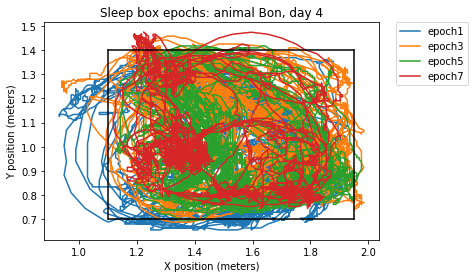

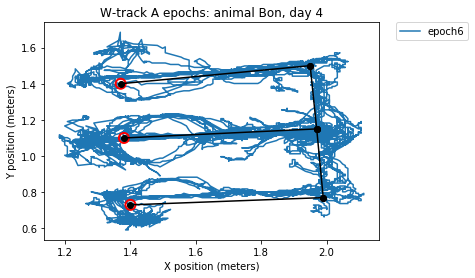

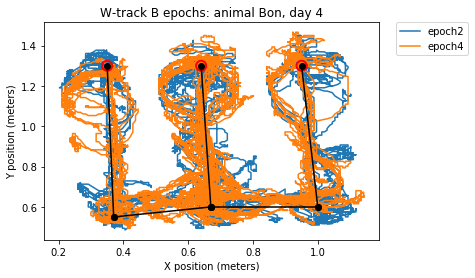

In [12]:
# --------------
# Hard-coded estimates of apparatus geometry for animal 'Bon', day 4 (in meters).
# For other datasets, replace these with accurate estimates from the position plots.
# --------------
# Sleep box polygon [lower left, upper left, upper right, lower right]
sleep_box_polygon = {'sleep box': [[1.1, 0.7], [1.1, 1.4], [1.95, 1.4], [1.95, 0.7]]}


# W-track A: 
# -- linearized segments represent the start/end of track segments/"arms"
# -- reward well locations
wtrackA_segments = {'left arm': [[1.4, 0.73], [1.99, 0.77]],
                    'left_branch': [[1.99, 0.77], [1.97, 1.15]],
                     'middle arm': [[1.38, 1.1], [1.97, 1.15]],
                     'right_branch': [[1.97, 1.15], [1.95, 1.5]],
                     'right arm': [[1.37, 1.4], [1.95, 1.5]]}
wtrackA_reward_wells = {'left reward well': [1.4, 0.73],
                        'middle reward well': [1.38, 1.1],
                        'right reward well': [1.37, 1.4]}

# W-track B
# -- linearized segments start/end 
# -- reward well locations
wtrackB_segments = {'left arm': [[0.37, 0.55], [0.35, 1.3]],
                     'middle arm': [[0.67, 0.6], [0.64, 1.3]],
                     'right arm': [[1.0, 0.6], [0.95, 1.3]],
                     'left_branch': [[0.37, 0.55], [0.67, 0.6]],
                     'right_branch': [[0.67, 0.6], [1.0, 0.6]]}
wtrackB_reward_wells = {'left reward well': [0.35, 1.3],
                        'middle reward well': [0.64, 1.3],
                        'right reward well': [0.95, 1.3]}


# --------------
# Find which epochs were on which apparatus (sleep box, w-track A, or w-track B)
# --------------
sleep_epochs, wtrackA_epochs, wtrackB_epochs = flh.separate_epochs_by_apparatus(data_dir, animal, day)


# --------------
# Plot animal position on each apparatus
# -------------
pos_series = position['spatial_series']
sleep_fig = flh.plot_position_by_epochs(animal, pos_series, np.array(epoch_time_ivls),
                                        sleep_epochs, 'Sleep box epochs: animal %s, day %s' % (animal, day))
wtrackA_fig = flh.plot_position_by_epochs(animal, pos_series, np.array(epoch_time_ivls),
                                          wtrackA_epochs, 'W-track A epochs: animal %s, day %s' % (animal, day))
wtrackB_fig = flh.plot_position_by_epochs(animal, pos_series, np.array(epoch_time_ivls),
                                          wtrackB_epochs, 'W-track B epochs: animal %s, day %s' % (animal, day))


# --------------
# Overlay plot of estimated apparatuses (estimated using the animal position plots)
# -------------
flh.overlay_apparatus_geom(sleep_fig, points={}, segments={}, polygons=sleep_box_polygon)
flh.overlay_apparatus_geom(wtrackA_fig, points=wtrackA_reward_wells, segments=wtrackA_segments, polygons={})
flh.overlay_apparatus_geom(wtrackB_fig, points=wtrackB_reward_wells, segments=wtrackB_segments, polygons={})


    


### Store apparatuses as NWB Apparatus objects (Frank Lab extension)

As shown above, we have three apparatuses: Sleep Box, W-track A, and W-track B. We represent each behavioral apparatus as a Frank Lab Apparatus (franklab.extensions.yaml), which uses a graph representation (i.e. nodes and edges) to represent the topology of a track. Each Node represents an important component of the apparatus:
- PointNode represents a point with an x/y position (e.g. reward well, novel object)
- SegmentNode represents a 1D line segment (e.g. linearized maze arm)
- PolygonNode represents a 2D area (e.g. open field / non-linearizable area)

Each Node object has a 'coords' field that describes its spatial geometry, which we found in the previous cell. Nodes sharing at least one coordinate can be represented as spatially connected by adding an Edge. For example, we can represent a reward well (PointNode) at the end of a linearized W-track arm (SegmentNode) by adding an Edge connecting those nodes. 

In [13]:
# ---------
# Apparatus 1: Sleep Box
#   The Sleep Box consists of a single PolygonNode representing the polygon area of the box.
#   The vertices of this polygon are defined in the "coords" property of the PolygonNode.
#   There are no edges since there is only one node.
# ---------
sleepbox_nodes = flh.get_franklab_nodes(points={}, segments={}, polygons=sleep_box_polygon) 
sleepbox_edges = []  
sleep_box_apparatus = fle.Apparatus(name='Sleep Box', nodes=sleepbox_nodes, edges=sleepbox_edges)

# ---------
# Apparatus 2: W-track A
#   This apparatus consists of several SegmentNodes representing the linearized segements of the W-track
#   and three PointNodes representing the reward wells at the end of the three "arms" of the track.
#   There are Edges connecting the SegmentNodes and PointNodes according to the topology of the
#   track (i.e. edges connecting track components that are, in fact, connected spatially).
# ---------
wtrack_A_nodes = flh.get_franklab_nodes(points=wtrackA_reward_wells, segments=wtrackA_segments, polygons={})
wtrack_A_edges = flh.find_edges(wtrack_A_nodes) # finds Nodes with 1 or more shared x/y coords
wtrack_A_apparatus = fle.Apparatus(name='W-track A', nodes=wtrack_A_nodes, edges=wtrack_A_edges)


# ---------
# Apparatus 3: W-track B
#   The second W-track used in this experiment has the same basic structure as W-track A, but
#   its geometry is distinct and thus should be represented as a separate Apparatus object.
# ---------
wtrack_B_nodes = flh.get_franklab_nodes(points=wtrackB_reward_wells, segments=wtrackB_segments, polygons={}) 
wtrack_B_edges = flh.find_edges(wtrack_B_nodes)
wtrack_B_apparatus = fle.Apparatus(name='W-track B', nodes=wtrack_B_nodes, edges=wtrack_B_edges)


print("Here are the three Apparatus objects. Notice that they consist of 'edges' and 'nodes'.")
print(sleep_box_apparatus)
print(wtrack_A_apparatus)
print(wtrack_B_apparatus)

Here are the three Apparatus objects. Notice that they consist of 'edges' and 'nodes'.

Sleep Box <class 'fl_extension.Apparatus'>
Fields:
  edges: { }
  nodes: { sleep box <class 'fl_extension.PolygonNode'> }


W-track A <class 'fl_extension.Apparatus'>
Fields:
  edges: { left arm<->left_branch <class 'fl_extension.Edge'>,  left reward well<->left arm <class 'fl_extension.Edge'>,  left_branch<->middle arm <class 'fl_extension.Edge'>,  left_branch<->right_branch <class 'fl_extension.Edge'>,  middle arm<->right_branch <class 'fl_extension.Edge'>,  middle reward well<->middle arm <class 'fl_extension.Edge'>,  right reward well<->right arm <class 'fl_extension.Edge'>,  right_branch<->right arm <class 'fl_extension.Edge'> }
  nodes: { left arm <class 'fl_extension.SegmentNode'>,  left reward well <class 'fl_extension.PointNode'>,  left_branch <class 'fl_extension.SegmentNode'>,  middle arm <class 'fl_extension.SegmentNode'>,  middle reward well <class 'fl_extension.PointNode'>,  right arm 

### Store the Apparatuses in the NWBFile object

After building the Apparatus objects, we store them in the "Behavior" [ProcessingModule](https://pynwb.readthedocs.io/en/latest/pynwb.base.html#pynwb.base.ProcessingModule), just like we did with the other behavioral data above.

In [14]:
# ---------
# Add all three Apparatuses to the "Behavior" ProcessingModule
# ---------
behav_mod.add_data_interface(sleep_box_apparatus)
behav_mod.add_data_interface(wtrack_A_apparatus)
behav_mod.add_data_interface(wtrack_B_apparatus)

print("Note that our fl_extension.Apparatus objects are now in the Behavior ProcessingModule:")
print(nwbf.modules['Behavior'])

Note that our fl_extension.Apparatus objects are now in the Behavior ProcessingModule:

Behavior <class 'pynwb.base.ProcessingModule'>
Fields:
  data_interfaces: { Head Direction <class 'pynwb.behavior.CompassDirection'>,  Position <class 'pynwb.behavior.Position'>,  Sleep Box <class 'fl_extension.Apparatus'>,  Speed <class 'pynwb.behavior.BehavioralTimeSeries'>,  W-track A <class 'fl_extension.Apparatus'>,  W-track B <class 'fl_extension.Apparatus'> }
  description: Behavioral data



### Represent behavioral tasks using Frank Lab NWB extension
We also represent each behavioral task that the animal may perform on an apparatus as a Frank Lab Task (franklab.extensions.yaml). This object simply contains a name and a detailed description of the task. For the dataset here, we only have two tasks: W-Alternation and Sleep.

We then store Task objects in the "Behavior" [ProcessingModule](https://pynwb.readthedocs.io/en/latest/pynwb.base.html#pynwb.base.ProcessingModule), just like we did with the other behavioral data above.

In [15]:
task_name = 'Sleep'
description = 'The animal sleeps or wanders freely around a small, empty box.'
behav_mod.add_data_interface(fle.Task(name=task_name, description=description))

task_name = 'W-Alternation'
task_description = 'The animal runs in an alternating W pattern between three neighboring arms of a maze.'
behav_mod.add_data_interface(fle.Task(name=task_name, description=task_description))

print("Note that we've added fl_extension.Task objects to our ProcessingModule:")
print(nwbf.modules['Behavior'])
print(nwbf.modules['Behavior']['W-Alternation'])
print(nwbf.modules['Behavior']['Sleep'])

Note that we've added fl_extension.Task objects to our ProcessingModule:

Behavior <class 'pynwb.base.ProcessingModule'>
Fields:
  data_interfaces: { Head Direction <class 'pynwb.behavior.CompassDirection'>,  Position <class 'pynwb.behavior.Position'>,  Sleep <class 'fl_extension.Task'>,  Sleep Box <class 'fl_extension.Apparatus'>,  Speed <class 'pynwb.behavior.BehavioralTimeSeries'>,  W-Alternation <class 'fl_extension.Task'>,  W-track A <class 'fl_extension.Apparatus'>,  W-track B <class 'fl_extension.Apparatus'> }
  description: Behavioral data


W-Alternation <class 'fl_extension.Task'>
Fields:
  description: The animal runs in an alternating W pattern between three neighboring arms of a maze.


Sleep <class 'fl_extension.Task'>
Fields:
  description: The animal sleeps or wanders freely around a small, empty box.



### Store epoch metadata in the NWBFile object
We store information about different sections of a day's worth of experiments as Epochs in the top-level [NWBFile.epochs](https://pynwb.readthedocs.io/en/latest/pynwb.file.html?highlight=epochs#pynwb.file.NWBFile.epochs) table. By default, there are required columns for 'start_time', 'stop_time', and 'tags'. We add additional metadata columns for the epoch's Task, Apparatus, etc. using the [NWBFile.add_epoch_column()](https://pynwb.readthedocs.io/en/latest/pynwb.file.html#pynwb.file.NWBFile.add_epoch_column) method. After we have all of the metadata columns set up, we add each epoch as a new row of the table using the [NWBFile.add_epoch()](https://pynwb.readthedocs.io/en/latest/pynwb.file.html#pynwb.file.NWBFile.add_epoch) method.

<i>Take a look under the PyNWB hood</i>:</br>
Each epoch occurs in a discrete time interval defined by its start and stop times. As such, the [NWBFile.epochs](https://pynwb.readthedocs.io/en/latest/pynwb.file.html?highlight=epochs#pynwb.file.NWBFile.epochs) table is an instance of [TimeIntervals](https://pynwb.readthedocs.io/en/latest/pynwb.epoch.html?highlight=TimeIntervals#pynwb.epoch.TimeIntervals), which is itself an instance of [DynamicTable](https://pynwb.readthedocs.io/en/latest/pynwb.core.html#pynwb.core.DynamicTable). Later, we will store electrodes and clustered units in two other DynamicTables. One of the advantages of using DynamicTables is it allows for adding arbitrary columns without having to write an extension.

In [16]:
# ---------
# Load epochs metadata from the Frank Lab Matlab files
# ---------
all_epochs_metadata = ns.parse_franklab_task_data(data_dir, animal, day)

# ---------
# Add metadata columns to the NWBFile.epochs table
# By default, it has columns for 'start_time', 'stop_time', and 'tags'.
# ---------
nwbf.add_epoch_column(name='exposure', description='number of exposures to this apparatus')
nwbf.add_epoch_column(name='task', description='behavioral task for this epoch')
nwbf.add_epoch_column(name='apparatus', description='behavioral apparatus for this epoch')

# ---------
# Iteratively add each epoch to the NWBFile.epochs table
# ---------
for epoch_num, epoch_metadata in all_epochs_metadata.items():
    
    # start and stop times were inferred from the behavior data earlier
    epoch_start_time, epoch_stop_time = epoch_time_ivls[epoch_num-1]  
    
    # meter per pixel ratio is also in the behavior data
    m_per_pixel = behavior_data[epoch_num]['cmperpixel'][0,0]/100  
    
    # Frank Lab Task (from the "Behavior" ProcessingModule)
    epoch_task = flh.get_franklab_task(epoch_metadata, behav_mod)
    
    # Frank Lab Apparatus (from the "Behavior" ProcessingModule)
    epoch_apparatus = flh.get_franklab_apparatus(epoch_metadata, behav_mod)
    
    epoch_exposure_num = ns.get_exposure_num(epoch_metadata)
    
    # Required column 'tags'. We do not presently use this.
    epoch_tags = ''
    
    # Add this epoch to the NWBFile.epochs table
    # Note that task and apparatus are references to the "Behavior" ProcessingModule, 
    # so they will not be unnecessarily duplicated within the NWBFile
    nwbf.add_epoch(start_time=epoch_start_time,
                   stop_time=epoch_stop_time,
                   exposure=epoch_exposure_num,
                   task=epoch_task,
                   apparatus=epoch_apparatus,
                   tags=epoch_tags)

In [17]:
print("Here is an example epoch from the table.\nNote that the 'task' and 'apparatus' columns point to our Frank Lab extension objects.\n")
print(nwbf.epochs.to_dataframe().iloc[0, :])

Here is an example epoch from the table.
Note that the 'task' and 'apparatus' columns point to our Frank Lab extension objects.

start_time                                          1.13641e+09
stop_time                                           1.13641e+09
exposure                                                     NA
task          \nSleep <class 'fl_extension.Task'>\nFields:\n...
apparatus     \nSleep Box <class 'fl_extension.Apparatus'>\n...
tags                                                         []
Name: 0, dtype: object


### Inspect the NWBFile
We have now added many of the core features of Frank Lab data to the NWBFile. Note that we have not used all of the available top-level fields ('analysis', 'stimulus', etc). These fields can be used to store other kinds of data as necessary for your lab and analysis pipeline. However, it is not advised to store temporary or in-progress analyses in the NWBFile, as NWB is meant to store stable versions of the data.

In [18]:
print(nwbf)


root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: { LFP <class 'pynwb.ecephys.LFP'> }
  analysis: { }
  devices: { NSpike acquisition system <class 'pynwb.device.Device'> }
  electrode_groups: { 04-01 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-02 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-03 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-04 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-05 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-06 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-07 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-08 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-10 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-11 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-12 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-13 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-14 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-15 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-17 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-18 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-19 <class 'pynwb.ecephys.ElectrodeGroup'>,

### Write the NWBFile to disk

In [20]:
nwb_filename = "{0}{1:02}.nwb".format(animal.lower(), day)
with pynwb.NWBHDF5IO(nwb_filename, mode='w') as iow:
    iow.write(nwbf)
print('Successfully wrote NWB file: ' + nwb_filename)

Successfully wrote NWB file: bon04.nwb


### Read our NWBFile from disk to test round-trip

In [ ]:
with pynwb.NWBHDF5IO(nwb_filename, mode='r') as ior:
    nwbf_read = ior.read()
    print(nwbf_read)